# Likelihood-Free Inference - Model Training

Ali Al Kadhim and Harrison B. Prosper<br>
Department of Physics, Florida State University<br>
Date: 22 April 2022<br>
Updated: 12 May 2022


## The Poisson Problem: A Single Count

Computing confidence intervals with exact coverage for the parameter $\theta$ of the Poisson distribution
\begin{align}
P(n | \theta) & =  \frac{e^{-\theta} \theta^n}{n!}, 
\end{align}

is a classic problem in statistics. Exact coverage means that the following is true

\begin{align}
    P\{ \theta \in [ \, \underline{\theta}(n), \, \overline{\theta}(n) \, ] \, \} \geq 1 - \alpha, \forall \textrm{ fixed values of } \theta , 
\end{align}

where $P$ is called the __coverage probability__, $1 - \alpha$ the confidence level (CL), and $\alpha$ the size of the associated hypothesis test. For a given experiment, the parameter $\theta$, the mean count, is presumed *fixed*. But the quantity $[ \, \underline{\theta}(n), \, \overline{\theta}(n) \, ]$ is a *random* interval which, in general, differs from one experiment to another. 

Jerzy Neyman[2], the inventor of __confidence intervals__, required these random intervals to have the following property.
In an infinite ensemble of experiments, each of which may be associated with a different *fixed* values of the parameters of the statistocal model, including $\theta$, the fraction of intervals that include $\theta$, that is, that *cover* $\theta$, is bounded below by the desired confidence level (CL). Moreover, this must hold true irrespective of the distribution of values of the parameters over the ensemble of experiments. 

In general, for multi-parameter problems, it is difficult to create random intervals with this property.  But for 1-parameter problems confidence intervals with exact coverage can be constructed. 

For 1-parameter problems, Neyman provided a simple algorithm to compute such intervals, which in this tutorial we illustrate by applying it to the Poisson distribution. The algorithm can be applied to any 1-parameter problem given the sampling distribution of a statistic that depends on the observations, in this example the Poisson count $n$. 
As the name implies, the __sampling distribution__ of $t$ is the distribution of $t$ induced by the underlying distribution of the potential observations. In this notebook, the statistic $t$ is simply $t(n) = \hat{\theta} = n$. 

A __statistic__ $t$ is a function of the data that compresses the data in such as way that, ideally, all relevant information in the data about the parameter $\theta$ is preserved.

What this means in practice is that the accuracy (suitably defined) with which $\theta$ can be estimated from $t$ is equal to the accuracy with which $\theta$ can be estimated directly from the data without compression. A statistic with this property, for a given parameter, is called a __sufficient statistic__ for that parameter. Obviously, the uncompressed data are sufficient statistics! The challenge is finding sufficient statistics that substantially compress the data.


### Algorithm
Define the *right* and *left* cumulative distribution functions of the
sampling distribution, $f_\theta(t)$, by
 \begin{align}
      D_R(x, \theta) & = \int_{t \geq x} f_\theta(t) \, dt \textrm{ and } \\ 
      D_L(x, \theta) & = \int_{t \leq x} f_\theta(t) \, dt.
 \end{align}
By solving the equations
\begin{align}
    D_R(x, \underline{\theta}) & = \alpha_R,\\
    D_L(x, \overline{\theta}) & =  \alpha_L,
\end{align}
with $x$ replaced by the observed values of the statistic $t$, say $t_0$,
one obtains the lower and upper limits $\underline{\theta}(t_0)$ and 
$\overline{\theta}(t_0)$, respectively, at confidence level CL
where $\text{CL} + \alpha_R + \alpha_L = 1$. For multi-parameter problems one can always create __confidence regions__, or sets, with exact coverage. The difficulty arises when one wishes to compute confidence regions, including intervals with exact coverage for a subset of the parameters irrespective of the values of the remaining parameters. Again, by exact coverage we mean coverage probabilities that never fall below the desired confidence level over any infinite ensemble of experiments.

Clearly for a given confidence level there are infinitely many ensembles of confidence intervals or regions that can be computed. Which interval or region is reported is a matter of convention. For a 1-parameter sampling distribution the following convention is often used: one sets $\alpha_R = \alpha_L = (1 - \text{CL})/2$ to arrive at __central intervals__.


### Application to the Poisson distribution
The Neyman algorithm, applied to the test statistic $t(n) = n$ for the
Poisson distribution, requires the functions 
 \begin{align}
      D_R(N, \theta) & = \sum_{k=N}^\infty \textrm{Poisson}(k, \theta) = P(N, \theta),\\
      \textrm{and   } D_L(N, \theta) & = \sum_{k=0}^N \textrm{Poisson}(k, \theta) = 1 - P(N+1, \theta) ,
 \end{align}
where $P(s, \theta)$ is the *normalized* lower incomplete gamma function[3].

In this notebook, we use the method of Ref.[1] to approximate $E(Z | \theta, N)$, that is, $D_L(N, \theta)$ using a simple deep neural network trained, that is, fitted, to data comprising the triplets $(Z_i, \theta_i, N_i)$. (See notebook __LFI_generate_data.ipynb__ for details.) 



### References
  1. Anne Lee et al., https://arxiv.org/abs/2107.03920
  2. Neyman, Jerzy (1937). "Outline of a Theory of Statistical Estimation Based on the Classical Theory of Probability". Philosophical Transactions of the Royal Society of London. Series A, Mathematical and Physical Sciences. 236 (767): 333–380. doi:10.1098/rsta.1937.0005.
  3. https://en.wikipedia.org/wiki/Incomplete_gamma_function. The normalized function is the unnormalized function divided by $\Gamma(s)$ and can be computed using scipy.special.gammainc($s$, $\theta$).

### Required modules

In [1]:
# standard system modules
import os, sys

# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard scientific computing module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

# standard symbolic algebra module
#import sympy as sm
#sm.init_printing()

# standard module serialize, that is, save, objects
import joblib as jb

# pytorch
import torch
import torch.nn as nn
#from torch.utils.data import Dataset

#  split data into a training set and a test set
from sklearn.model_selection import train_test_split

# to reload modules
import importlib

%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

### Load data

In [3]:
datafile = 'data1.db'
print('loading %s' % datafile)
data = jb.load(datafile)

target = 'Z1'
source = ['theta', 'N']
data[:5]

loading data1.db


,Z1,Z2,theta,N
0,0,1,9.363525,4
1,0,0,10.274183,8
2,0,0,6.764226,8
3,1,1,0.804674,2
4,0,1,4.275650,2


### Define functions
$
\begin{align}
      D_R(N, \theta) & = \sum_{k=N}^\infty \textrm{Poisson}(k, \theta) = P(N, \theta),\\
      \textrm{and   } D_L(N, \theta) & = \sum_{k=0}^N \textrm{Poisson}(k, \theta) = 1 - P(N+1, \theta).
\end{align}
$

In [4]:
def DR(x, theta):
    return sp.special.gammainc(x, theta)

def DL(x, theta):
    return 1 - sp.special.gammainc(x+1, theta)

### Plot data

Check that data make sense. Compute $D_L$ by histogramming the data and compare it to $D_L$ computed exactly.


Note: __matplotlib__ has two graphics systems: 1) function-based and 2) object-based. The function below illustrates the object-based system.

In [5]:
# Check that histogrammed data agree with exact calculation of DL.

# Check that histogrammed data agrees with exact calculation of DL.

XMIN  = 0
XMAX  = 20
XBINS = 200

def hist_data(data, N, 
              xbins=XBINS, 
              xmin=XMIN, 
              xmax=XMAX):
    
    xrange = (xmin, xmax)
    
    select = data.N == N

    # weighted histogram   (count the number of ones per bin)
    # y1 - counts
    # bb - bin boundaries (including boundary of rightmost bin)
    y1, bb = np.histogram(data.theta[select], 
                          bins=xbins, 
                          range=xrange, 
                          weights=data.Z1[select]) 

    # unweighted histogram (count number of ones and zeros per bin)
    yt, _  = np.histogram(data.theta[select], 
                          bins=xbins, 
                          range=xrange)

    # approximation of DL(N, x)
    y =  y1 / yt    

    # exact DL

    x = (bb[1:]+bb[:-1])/2
    p = DL(N, x)
    
    return (y, p, bb)

In [6]:
def plot_data(data, func, Nmin, Nmax,
              gfile='fig_data.png', 
              fgsize=(10, 6)):
    
    # make room for up to 6 sub-plots
    fig, ax = plt.subplots(nrows=2, 
                           ncols=3, 
                           figsize=fgsize)
    
    # padding
    plt.subplots_adjust(hspace=0.01)
    plt.subplots_adjust(wspace=0.20)
    
    # use flatten() to convert a numpy array of 
    # shape (nrows, ncols) to a 1-d array of
    # length nrows * ncols
    ax = ax.flatten()
    
    for j, N in enumerate(range(Nmin, Nmax+1)):
        
        # compute DL
        # y  - DL approximation
        # p  - DL exact
        # bb - bin boundaries (in theta) 
        y, p, bb = func(data, N)
        
        xmin = bb[0]
        xmax = bb[-1]
        ax[j].set_xlim(xmin, xmax)
        ax[j].set_ylim(0, 1)
        ax[j].set_xlabel(r'$\theta$', fontsize=FONTSIZE)
        ax[j].set_ylabel(r'$E(Z|\theta)$', fontsize=FONTSIZE)
        
        x = (bb[1:]+bb[:-1])/2 
        ax[j].plot(x, y, 'b', lw=2, label='approx')
        ax[j].plot(x, p, 'r', lw=2, label='exact')
        
        ax[j].grid(True, which="both", linestyle='-')
        ax[j].text(10.2, 0.42, r'$N = %d$' % N, fontsize=FONTSIZE) 

        ax[j].legend(loc='upper right')
        
    # hide unused sub-plots
    for k in range(Nmax+1-Nmin, len(ax)):
        ax[k].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(gfile)
    plt.show()

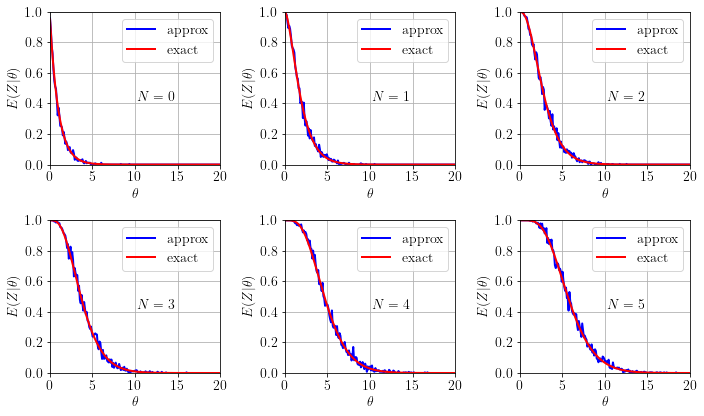

In [7]:
Nmin, Nmax = 0, 5
plot_data(data, hist_data, Nmin, Nmax) 

### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

The validation set will be some small fraction of the training set and will be used to decide when to stop the training.

In [8]:
# Fraction of the data assigned as test data
fraction = 1/102
# Split data into a part for training and a part for testing
train_data, test_data = train_test_split(data, 
                                         test_size=fraction)

# Split the training data into a part for training (fitting) and
# a part for validating the training.
fraction = 1/101
train_data, valid_data = train_test_split(train_data, 
                                          test_size=fraction)

# reset the indices in the dataframes and drop the old ones
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
test_data  = test_data.reset_index(drop=True)

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

train_data[:5][source]

train set size:        500000
validation set size:     5000
test set size:           5000


,theta,N
0,19.058267,9
1,7.885420,9
2,18.455130,3
3,12.604207,5
4,6.384315,3


Split data into targets $t$ and inputs $\mathbf{x}$

In [9]:
def split_t_x(df, target, source):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    t = np.array(df[target])
    x = np.array(df[source])
    return (t, x)

train_t, train_x = split_t_x(train_data, target, source)
valid_t, valid_x = split_t_x(valid_data, target, source)
test_t,  test_x  = split_t_x(test_data,  target, source)

### Return a (random) batch of data from the training set

In [10]:
def get_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = rnd.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    return (batch_x, batch_t)

### Empirical risk (that is, average loss)

The empirical risk, which is the __objective function__ we shall minimize, is defined as

\begin{align}
R_M(\theta) & = \frac{1}{M}\sum_{m=1}^M L(t_m, f_m),
\end{align}

where 

\begin{align*}
    f_m & \equiv f(\mathbf{x}_m, \theta),\\ \\ \textrm{and} \\
    L(t, f) &= (t - f)^2
\end{align*}

The empirical risk $R_M$ approximates the __risk__

\begin{align}
R[f] & = \int \cdots \int \, p(t, \mathbf{x}) \, L(t, f(\mathbf{x}, \theta)) \, dt \, d\mathbf{x},
\end{align}

which is a __functional__ of the model $f$. The quantity $p(t, \mathbf{x}) \, dt\, d\mathbf{x}$ is the probability distribution from which the sample $\{ (t_m, \mathbf{x}_m), m = 1,\cdots, M \}$ is presumed to have been drawn. 

In [11]:
# Note: there are several average loss functions available 
# in pytorch, but it's useful to know how to create your own.
def average_loss(f, t):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)

This function is used to validate the model while the it is being fitted.

In [12]:
def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t)

### Function to execute training loop

In [13]:
def train(model, optimizer, avloss, getbatch,
          train_x, train_t, 
          valid_x, valid_t,
          batch_size, 
          n_iterations, traces, 
          step=50):
    
    # to keep track of average losses
    xx, yy_t, yy_v = traces
    
    n = len(valid_x)
    
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        batch_x, batch_t = getbatch(train_x, train_t, batch_size)
        
        # convert the numpy arrays batch_x and batch_t to tensor 
        # types. The PyTorch tensor type is the magic that permits 
        # automatic differentiation with respect to parameters. 
        # However, since we do not need to take the derivatives
        # with respect to x and t, we disable this feature
        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float()
            t = torch.from_numpy(batch_t).float()      

        # compute the output of the model for the batch of data x
        # Note: outputs is 
        #   of shape (-1, 1), but the tensor targets, t, is
        #   of shape (-1,)
        # In order for the tensor operations with outputs and t
        # to work correctly, it is necessary that they have the
        # same shape. We can do this with the reshape method.
        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, valid_x[:n], valid_t[:n])

            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], acc_t, acc_v))
            else:
                xx.append(xx[-1] + step)
                print("\r%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], acc_t, acc_v), end='')
                
            yy_t.append(acc_t)
            yy_v.append(acc_v)
    print()      
    return (xx, yy_t, yy_v)

In [14]:
def plot_average_loss(traces):
    
    xx, yy_t, yy_v = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title("Average loss")
    
    ax.plot(xx, yy_t, 'b', lw=2, label='Training')
    ax.plot(xx, yy_v, 'r', lw=2, label='Validation')

    ax.set_xlabel('Iterations', fontsize=FONTSIZE)
    ax.set_ylabel('average loss', fontsize=FONTSIZE)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')

    plt.show()

### Define model $f(\mathbf{x}, \theta)$

In [15]:
%%writefile dnnmodel.py

import torch
import torch.nn as nn

class Model(nn.Module):
    
    def __init__(self, n_inputs=2, n_nodes=20, n_layers=5):

        # call constructor of base (or super, or parent) class
        super(Model, self).__init__()

        self.layers = []
        
        # create input layer
        self.layer0 = nn.Linear(n_inputs, n_nodes)
        self.layers.append(self.layer0)

        # create "hidden" layers
        for l in range(1, n_layers):
            cmd = 'self.layer%d = nn.Linear(%d, %d)' % \
            (l, n_nodes, n_nodes)
            exec(cmd)
            cmd = 'self.layers.append(self.layer%d)' % l
            exec(cmd)
          
        # create output layer
        cmd = 'self.layer%d = nn.Linear(%d, 1)' % (n_layers, n_nodes)
        exec(cmd)
        cmd = 'self.layers.append(self.layer%d)' % n_layers
        exec(cmd)

    # define (required) method to compute output of network
    def forward(self, x):
        y = x
        for layer in self.layers[:-1]:
            y = layer(y)
            y = torch.relu(y)
        y = self.layers[-1](y)
        y = torch.sigmoid(y)
        return y


Overwriting dnnmodel.py


In [16]:
import dnnmodel
importlib.reload(dnnmodel)
model = dnnmodel.Model()
print(model)

Model(
  (layer0): Linear(in_features=2, out_features=20, bias=True)
  (layer1): Linear(in_features=20, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (layer4): Linear(in_features=20, out_features=20, bias=True)
  (layer5): Linear(in_features=20, out_features=1, bias=True)
)


### Train!

Instantiate an optimizer, then train

In [17]:
learning_rate = 1.e-3
optimizer     = torch.optim.Adam(model.parameters(), 
                                 lr=learning_rate) 

traces = ([], [], [])
traces_step = 10

Iteration vs average loss
 iteration	 train-set	 valid-set
         0	  0.264638	  0.263988
     19990	  0.061724	  0.061372
Iteration vs average loss
 iteration	 train-set	 valid-set
     29990	  0.061578	  0.061278


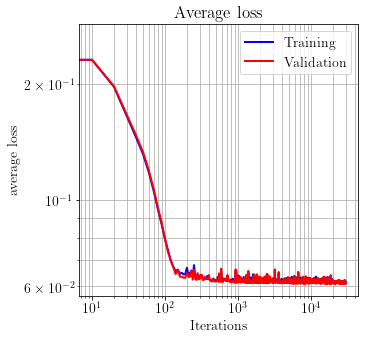

In [18]:
n_batch       = 50
n_iterations  = 20000

traces = train(model, optimizer, average_loss,
               get_batch,
               train_x, train_t, 
               valid_x, valid_t,
               n_batch, 
               n_iterations,
               traces,
               step=traces_step)

n_batch       = 500
n_iterations  = 10000

traces = train(model, optimizer, average_loss,
               get_batch,
               train_x, train_t, 
               valid_x, valid_t,
               n_batch, 
               n_iterations,
               traces,
               step=traces_step)

plot_average_loss(traces)

In [19]:
def usemodel(data, N,               
             xbins=XBINS, 
             xmin=XMIN, 
             xmax=XMAX):
    
    # bin boundaries
    h = (xmax-xmin)/xbins
    bb= np.arange(xmin, xmax + h, h)
    
    # bin centers
    x = (bb[1:]+bb[:-1])/2
    d = torch.Tensor([[q, N] for q in x])
    
    # compute using trained, that is, fitted, model
    model.eval()
    y = model(d).detach().numpy()
    p = DL(N, x)
    
    return y, p, bb

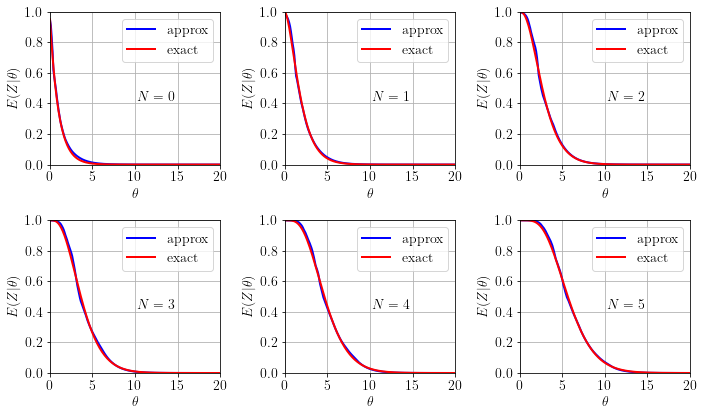

In [20]:
plot_data(data, usemodel, Nmin, Nmax, gfile='fig_model_vs_DL.png') 

### Computing 90% upper limits

Let's now compute some upper limits using our trained model and compare with the exact calculation.

In [21]:
CL = 0.90
ALPHA = 1 - CL

def computeUpperLimit(n, func):
    dn   = 2*np.sqrt(n)         
    amin = n 
    amax = n + dn + 5
    u    = op.brentq(func, amin, amax, args=(n)) 
    return u

def func1(u, n):
    return DL(n, u) - ALPHA

def func2(u, n):
    model.eval()
    X = torch.Tensor([[u, n]])
    return model(X).detach().numpy() - ALPHA

print('%10s\t%10s\t%10s' % ('count', 'exact', 'approx'))

for n in np.arange(0, 11, 1):
    u1 = computeUpperLimit(n, func1)
    u2 = computeUpperLimit(n, func2)
    print('%10d\t%10.1f\t%10.1f' % (n, u1, u2))

     count	     exact	    approx
         0	       2.3	       2.5
         1	       3.9	       4.0
         2	       5.3	       5.4
         3	       6.7	       6.8
         4	       8.0	       8.2
         5	       9.3	       9.4
         6	      10.5	      10.5
         7	      11.8	      11.6
         8	      13.0	      12.8
         9	      14.2	      13.9
        10	      15.4	      15.0
